In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import keras
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from keras.layers import Activation, Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, History
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K

Using TensorFlow backend.


In [2]:
# MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def corrupt_mnist_img(rng, img, value):
    """Corrupt a single MNIST image.
    Note that the image itself is MODIFIED.
    :param rng: instance of numpy.random.RandomState
    :param img: image to modify. ndarray or compatible
    :param value: pixel value to use for corrupting the image
    :return: modified image
    """
    # Choose square size
    s = rng.randint(7, 14)
    # Choose top-left corner position
    x = rng.randint(0, 28 - s)
    y = rng.randint(0, 28 - s)
    # Draw square
    img[..., y:y + s, x:x + s] = value
    # Return object for convenience
    return img


def corrupt_mnist_copy(x_train, value=255, seed=0):
    """Create a corrupted copy of the MNIST dataset
    :param x_train: ndarray of images. Shape: (N, ..., H, W)
    :param value: pixel value to use for corrupting the image
    :param seed: seed to use for the random number generator
    :return: ndarray of corrupted images
    :return: ndarray of corrupted images
    """
    rng = np.random.RandomState(seed)
    corrupted_x_train = x_train.copy()
    for img in corrupted_x_train:
        corrupt_mnist_img(rng, img, value)
    return corrupted_x_train

In [0]:
image_size = x_train.shape[1]

x_train_start = x_train
x_test_start = x_test
x_train_noisy_start = corrupt_mnist_copy(x_train)
x_test_noisy_start = corrupt_mnist_copy(x_test)
x_test_noisy_reshaped = np.reshape(x_test_noisy_start, [-1, image_size, image_size, 1])
x_test_noisy_reshaped = x_test_noisy_reshaped / 255

In [0]:
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

x_train_noisy = corrupt_mnist_copy(x_train)
x_test_noisy = corrupt_mnist_copy(x_test)

x_train = x_train / 255
x_test = x_test  / 255
x_train_noisy = x_train_noisy / 255
x_test_noisy = x_test_noisy / 255

# 1.   **Data Visualization**



[ORIGINAL DATA]


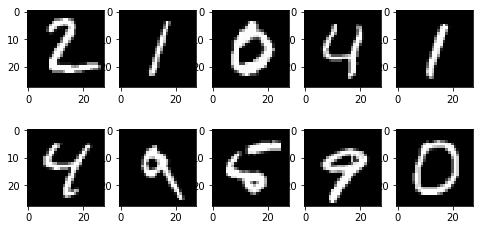

In [6]:
print("[ORIGINAL DATA]")
fig=plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i in range(1, columns*rows + 1):
    img = x_test_start[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

[CORRUPTED DATA]


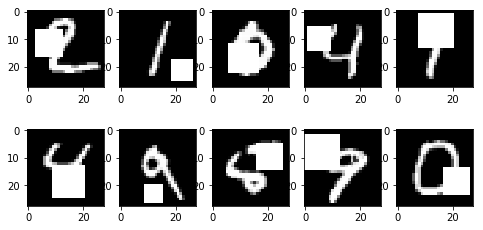

In [7]:
print("[CORRUPTED DATA]")
fig=plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i in range(1, columns*rows + 1):
    img = x_test_noisy_start[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [0]:
# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16

In [0]:
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [10]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [0]:
# Shape info needed to build Decoder Model
shape = K.int_shape(x)

In [0]:
# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [0]:
# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')

In [0]:
# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [0]:
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

In [0]:
# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')

# 2.   **Model Summary**

[TEXT SUMMARY]

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


[IMAGE SUMMARY]



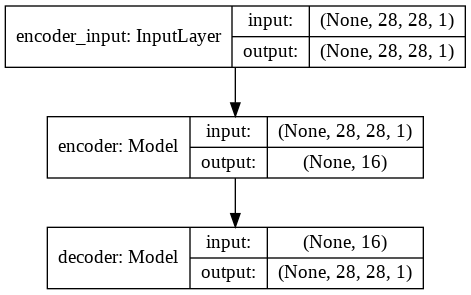

In [17]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

print("[TEXT SUMMARY]\n")
autoencoder.summary()

print("\n\n[IMAGE SUMMARY]\n")
plot_model(autoencoder, to_file = 'AE_mnist.png', show_shapes = True)

In [18]:
autoencoder.compile(loss='mse', optimizer='adam')

# 3.  **Plots of losses per epoch**











Training: 5 Epochs
dict_keys(['val_loss', 'loss'])


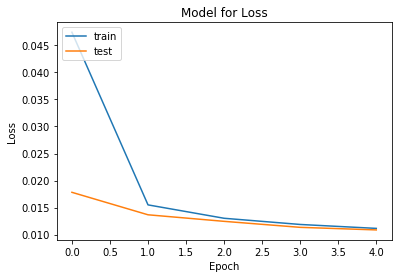

In [19]:
# Train the autoencoder
epochs = 5
history = autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=epochs,
                batch_size=batch_size, verbose=0)

print("Training:" , epochs , "Epochs")
autoencoder.history

# List all data in history
print(history.history.keys())
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model for Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

In [21]:
# Display at least 5 samples for the results
rows, cols = 1, 5
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy_reshaped[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# 4. **Results (5 Samples)**



	 [TOP ROW] Original Images
	 [MIDDLE ROW] Corrupted Images
	 [LAST ROW] Restored Images


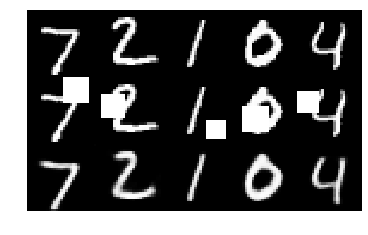

In [22]:
plt.axis('off')
print('\t [TOP ROW] Original Images\n\t [MIDDLE ROW] Corrupted Images\n\t [LAST ROW] Restored Images')
plt.imshow(imgs, interpolation='none', cmap='gray')
# Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()